In [2]:
import pickle

# Load train/test splits and TF-IDF vectorizer
X_train, X_test, y_train, y_test, tfidf = pickle.load(open("../data/processed_spam_data.pkl", "rb"))

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (4457, 5000), Test size: (1115, 5000)


In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

fitted_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(f"{name} trained successfully.")


Naive Bayes trained successfully.
Logistic Regression trained successfully.
Random Forest trained successfully.


In [4]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_fscore_support

def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    print(f"==== {name} ====")
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
    if roc:
        print(f"ROC-AUC: {roc:.3f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": roc}


In [5]:
results = {}
for name, model in fitted_models.items():
    results[name] = evaluate_model(model, X_test, y_test, name)


==== Naive Bayes ====
Accuracy: 0.969 | Precision: 1.000 | Recall: 0.765 | F1: 0.867
ROC-AUC: 0.983

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       1.00      0.77      0.87       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115

==== Logistic Regression ====
Accuracy: 0.958 | Precision: 1.000 | Recall: 0.685 | F1: 0.813
ROC-AUC: 0.983

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98       966
           1       1.00      0.68      0.81       149

    accuracy                           0.96      1115
   macro avg       0.98      0.84      0.89      1115
weighted avg       0.96      0.96      0.95      1115

==== Random Forest ====
Accuracy: 0.977 | Precision: 1.000 | Recall: 0.826 | F1: 0.904
R

In [6]:
import pandas as pd

results_df = pd.DataFrame(results).T
print(results_df)


                     accuracy  precision    recall        f1   roc_auc
Naive Bayes          0.968610        1.0  0.765101  0.866920  0.982555
Logistic Regression  0.957848        1.0  0.684564  0.812749  0.983430
Random Forest        0.976682        1.0  0.825503  0.904412  0.984496



==== Naive Bayes ====
Accuracy: 0.9686 | Precision: 1.0000 | Recall: 0.7651 | F1: 0.8669 | ROC-AUC: 0.9826

==== Logistic Regression ====
Accuracy: 0.9578 | Precision: 1.0000 | Recall: 0.6846 | F1: 0.8127 | ROC-AUC: 0.9834

==== Random Forest ====
Accuracy: 0.9767 | Precision: 1.0000 | Recall: 0.8255 | F1: 0.9044 | ROC-AUC: 0.9845

==== Linear SVM ====
Accuracy: 0.9857 | Precision: 0.9926 | Recall: 0.8993 | F1: 0.9437 | ROC-AUC: 0.9871


Final Comparison:
                  Model  Accuracy  Precision    Recall        F1   ROC_AUC
0          Naive Bayes  0.968610   1.000000  0.765101  0.866920  0.982555
1  Logistic Regression  0.957848   1.000000  0.684564  0.812749  0.983430
2        Random Forest  0.976682   1.000000  0.825503  0.904412  0.984496
3           Linear SVM  0.985650   0.992593  0.899329  0.943662  0.987084


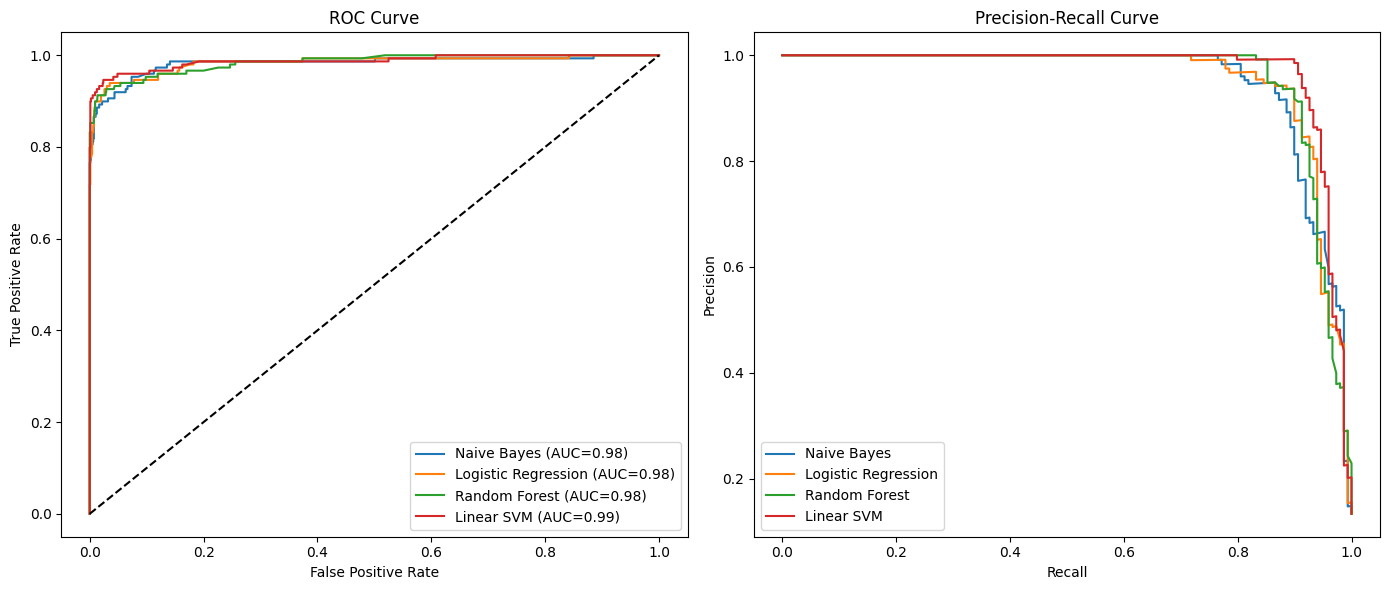

In [7]:
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    precision_recall_curve, roc_curve, auc
)
from sklearn.preprocessing import LabelBinarizer



# =========================
# Define Models
# =========================
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Linear SVM": LinearSVC(random_state=42)   # New model
}

results = []
y_test_bin = LabelBinarizer().fit_transform(y_test).ravel()

# =========================
# Training + Evaluation
# =========================
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Some models don't have predict_proba (like LinearSVC), so handle carefully
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        # decision_function works for LinearSVC
        y_scores = model.decision_function(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test_bin, y_scores)

    results.append([name, acc, prec, rec, f1, roc])
    
    print(f"\n==== {name} ====")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}")

# =========================
# Save Results Table
# =========================
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1", "ROC_AUC"])
print("\n\nFinal Comparison:\n", df_results)

# =========================
# ROC and Precision-Recall Curves
# =========================
plt.figure(figsize=(14,6))

# ROC Curve
plt.subplot(1,2,1)
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test_bin, y_scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr, tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# Precision-Recall Curve
plt.subplot(1,2,2)
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)
    precision, recall, _ = precision_recall_curve(y_test_bin, y_scores)
    plt.plot(recall, precision, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()
